In [55]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

## 1. Sensor with bias


The sensor is biased. In particular,
$$y_t = Cx_t + b_t + v_t,$$
where $v_t$ is meaurement noise, $b_t$ is a *bias* term which is constant or allowed to change slowly.

We can model the bias as
$$b_{t+1} = b_t + w^b_t,$$
where $w^b_t$ is a zero-mean iid Gaussian noise term. Note that ${\rm I\!E}[b_t] = {\rm I\!E}[b_{t+1}]$.

Assumption: $w^b_t \overset{\rm iid}{\sim} \mathcal{N}(0, Q^b)$ independent of $w_t$ and all other noise terms.

Let us see how $b_t$ may look like: we'll look at paths of $(b_t)_t$

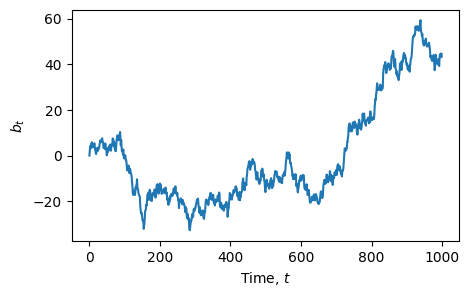

In [52]:
Qb = 2
n_sim = 1000
b_cache = np.zeros((n_sim, 1))
for i in range(n_sim - 1):
    wbi = np.random.normal(0, np.sqrt(Qb), 1)
    b_cache[i+1] = b_cache[i] + wbi

plt.figure(figsize=(5, 3))
plt.plot(b_cache)
plt.xlabel('Time, $t$')
plt.ylabel('$b_t$')
plt.show()

**Mini exercise:** Generate $r=500$ paths $(b_t)_t$ and plot them in the same figure

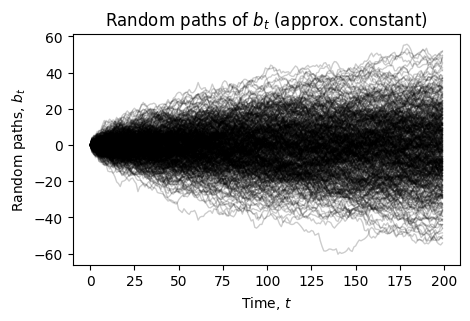

In [54]:
r = 500
n_sim = 200
b_cache = np.zeros((n_sim, r))

for i in range(r):
    for t in range(n_sim - 1):
        wbi = np.random.normal(0, np.sqrt(Qb), 1)
        b_cache[t+1, i] = b_cache[t, i] + wbi[0]

plt.figure(figsize=(5, 3))
plt.plot(b_cache, 'k', linewidth=1, alpha=0.2)
plt.xlabel('Time, $t$')
plt.ylabel('Random paths, $b_t$')
plt.title('Random paths of $b_t$ (approx. constant)')
plt.show()

**Mini exercise:** Increase $Q^b$ and see what happens.

We define the state variable $z_t = (x_t, b_t)$; we will estimate $z_t$ with a KF. The system dynamics becomes
$$\begin{align*}
        z_{t+1} = & \begin{bmatrix} A \\ & I \end{bmatrix}z_t + \tilde{w}_t,
        \\
        y_{t} =   & \begin{bmatrix} C & I \end{bmatrix}z_t + v_t,
\end{align*}$$
where $\tilde{w}_t = (w_t, w^b_t) \sim \mathcal{N}(0, \tilde{Q})$ with
$$\tilde{Q} = \begin{bmatrix}Q \\ & Q^b\end{bmatrix}.$$
We can now design a KF for this system.

More examples at https://am-press.github.io/posts/maths/kalman-6/

### 1.1. Example

Consider the system
$$\begin{aligned}
x_{t+1} =& \begin{bmatrix}0.98& -0.7 \\ 0.1& 0.9\end{bmatrix}x_t + w_t,
\\
y_t =& \begin{bmatrix}1 & 1\end{bmatrix}x_t + b_t + v_t,
\end{aligned}$$
where $w_t$ and $v_t$ satisfy the standard assumptions of the Kalman filter (which?) and have covariances $Q$ and $R$ respectively given by
$$Q = \begin{bmatrix}0.2& 0.005 \\ 0.005 & 0.001\end{bmatrix}, R = 10.$$


In [72]:
# System data
A = np.array([[0.98, -0.7],
              [0.1, 0.9]])
C = np.array([[1, 1]])
Q = np.array([[0.2, 0.005],
              [0.005, 0.001]])
R = np.array([[10]])

A_tilde = sp.linalg.block_diag(A, 1)
C_tilde = np.hstack((C, [[1]]))
